In [33]:
import numpy as np
import sympy as syp
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D


In [34]:
def compute_total_energy(u, u_old, Dx, Dy, Dt, c):
    du_dt = (u - u_old) / Dt
    kinetic = 0.5 * du_dt**2

    du_dx = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2 * Dx)
    du_dy = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / (2 * Dy)
    potential = 0.5 * c**2 * (du_dx**2 + du_dy**2)

    total_energy = np.sum(kinetic + potential) * Dx * Dy
    return total_energy


In [ ]:
Lx, Ly = 1.0, 1.0        # size
Nx, Ny = 100, 100        # number of grid points
c = 1.0                  # wave speed
T = 10.0                  # total time


x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
Dx = x[1] - x[0]
Dy = y[1] - y[0]
Dt = 0.4 * min(Dx, Dy) / c
Nt = int(T / Dt)


# Initialize empty fields
u = np.zeros((Nx, Ny))
u_new = np.zeros((Nx, Ny))
u_old = np.zeros((Nx, Ny))

# Add in motion to center
X, Y = np.meshgrid(x, y, indexing='ij')
u = np.exp(-100 * ((X - Lx/2)**2 + (Y - Ly/2)**2))
u_old = np.copy(u)

# # Initial condition: right-traveling sine-modulated wave
# X, Y = np.meshgrid(x, y, indexing='ij')
# u = np.sin(2 * np.pi * X / Lx) * np.exp(-100 * (Y - Ly/2)**2)
# u_old = u - Dt * c * (2 * np.pi / Lx) * np.cos(2 * np.pi * X / Lx) * np.exp(-100 * (Y - Ly/2)**2)

# # Single wave??????
# wave_profile = np.sin(2 * np.pi * x / Lx)
# u = np.repeat(wave_profile[:, np.newaxis], Ny, axis=1)  # (Nx, Ny)
# velocity_profile = -Dt * c * (2 * np.pi / Lx) * np.cos(2 * np.pi * x / Lx)
# u_old = np.repeat((wave_profile + velocity_profile)[:, np.newaxis], Ny, axis=1)


# Solve IVBP
frames = []
energies = []
times = []

for i in range(1, Nx-1):
    for j in range(1, Ny-1):
        laplace = ((u[i+1, j] - 2*u[i, j] + u[i-1, j]) / Dx**2 +
                   (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / Dy**2)
        u_new[i, j] = u[i, j] + 0.5 * Dt**2 * c**2 * laplace

frames.append(u.copy())

for n in range(1, Nt):
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            laplace = ((u[i+1, j] - 2*u[i, j] + u[i-1, j]) / Dx**2 +
                       (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / Dy**2)
            u_new[i, j] = 2*u[i, j] - u_old[i, j] + Dt**2 * c**2 * laplace

    u_old[:], u[:] = u[:], u_new[:]

    if n % 10 == 0:
        frames.append(u.copy())
        energy = compute_total_energy(u, u_old, Dx, Dy, Dt, c)
        energies.append(energy)
        times.append(n * Dt)



In [36]:
# Create video
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.pcolormesh(X, Y, frames[0], shading='auto', cmap='viridis', vmin=-1, vmax=1)
fig.colorbar(cax)

def animate(i):
    cax.set_array(frames[i].ravel())
    return cax,

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=100, blit=True)

ani.save("wave_propagation.mp4", writer="ffmpeg")
plt.close()


In [37]:
# Create figure and 3D axes
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')


surf = [ax.plot_surface(X, Y, frames[0], cmap='viridis', vmin=-1, vmax=1)]
ax.set_zlim(-1, 1)
def animate(i):
    surf[0].remove()
    surf[0] = ax.plot_surface(X, Y, frames[i], cmap='viridis', vmin=-1, vmax=1)
    return surf[0],

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=100, blit=False)

ani.save("wave_propagation_3d.mp4", writer="ffmpeg")
plt.close()


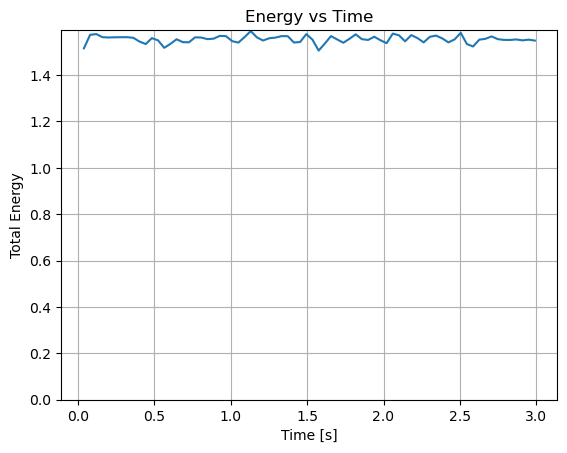

In [ ]:
# Plot Energy
plt.figure()
plt.plot(times, energies)
plt.xlabel('Time [s]')
plt.ylabel('Total Energy')
plt.title('Energy vs Time')
plt.grid(True)
plt.ylim(bottom=0)
plt.show()